# Finding Lanes

## Image Processing

### Imports

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

### List images

In [2]:
import os
os.listdir("test_images/")

['solidYellowCurve.jpg',
 'solidYellowLeft.jpg',
 'solidYellowCurve2.jpg',
 'solidWhiteRight.jpg',
 'whiteCarLaneSwitch.jpg',
 'solidWhiteCurve.jpg']

### Read one image

In [3]:
image = mpimg.imread('test_images/solidWhiteCurve.jpg')

In [4]:
type(image)

numpy.ndarray

In [5]:
image.shape

(540, 960, 3)

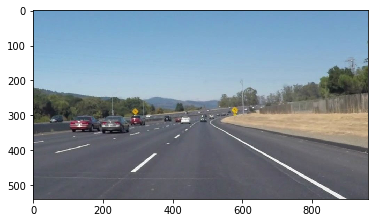

In [6]:
plt.imshow(image)

### Read all images in folder

In [7]:
images = [mpimg.imread('test_images/' + image_name) for image_name in os.listdir("test_images/")]

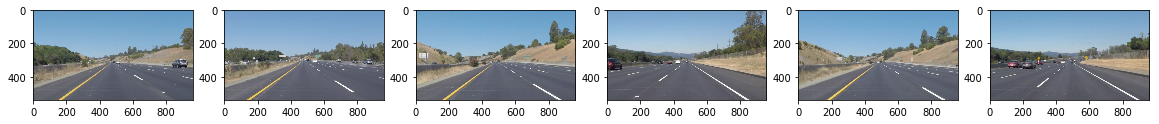

In [8]:
f, axarr = plt.subplots(1, len(images), figsize=(20,20))
for index, image in enumerate(images):
    axarr[index].imshow(image)

plt.show()

## Detecting White Lanes

In [9]:
# set threshold values
red_threshold = 200
green_threshold = 200
blue_threshold = 200
rgb_threshold = [red_threshold, green_threshold, blue_threshold]

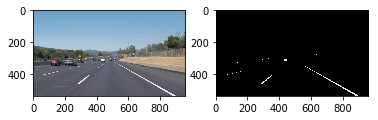

In [10]:
color_thresholds = (image[:,:,0] < rgb_threshold[0]) \
            | (image[:,:,1] < rgb_threshold[1]) \
            | (image[:,:,2] < rgb_threshold[2])
        
color_select = np.copy(image)
color_select[color_thresholds] = [0,0,0]

# Display the image   
f, axarr = plt.subplots(1,2)
axarr[0].imshow(image) 
axarr[1].imshow(color_select) 
plt.show()

## Region Masking

In [11]:
ysize = image.shape[0]
xsize = image.shape[1]
line_image = np.copy(image)

# Define the region of interest 
# Note: the origin (x=0, y=0) is in the upper left corner
left_bottom = [0, 539]
right_bottom =[900, 539]
apex = [500, 300]

In [12]:
# Find the polynomials for three lines that fit the region of interest
fit_left = np.polyfit((left_bottom[0], apex[0]), (left_bottom[1], apex[1]), 1)
fit_right = np.polyfit((right_bottom[0], apex[0]), (right_bottom[1], apex[1]), 1)
fit_bottom = np.polyfit((left_bottom[0], right_bottom[0]), (left_bottom[1], right_bottom[1]), 1)

# Find the points between the lines
XX, YY = np.meshgrid(np.arange(0, xsize), np.arange(0, ysize))
region_thresholds = (YY > (XX*fit_left[0] + fit_left[1])) & \
                    (YY > (XX*fit_right[0] + fit_right[1])) & \
                    (YY < (XX*fit_bottom[0] + fit_bottom[1]))

In [13]:
# Color in red every white point inside the region
line_image[~color_thresholds & region_thresholds] = [255,0,0]

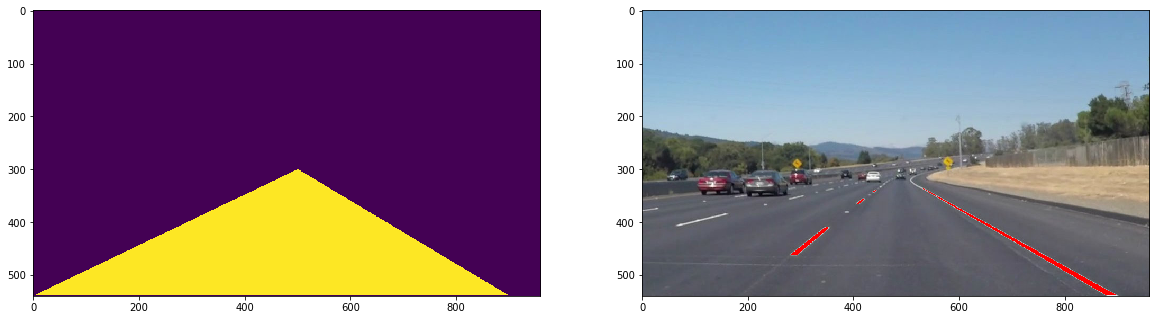

In [14]:
f, axarr = plt.subplots(1,2, figsize=(20,20))
axarr[0].imshow(region_thresholds) 
axarr[1].imshow(line_image) 
plt.show()

# Finding Lanes of Any Color

## Canny Edge Detection

In [15]:
import cv2

gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) #grayscale conversion

In [16]:
# Define a kernel size for Gaussian smoothing / blurring
# Note: cv2.Canny() also applies a 5x5 Gaussian internally
kernel_size = 9
blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size), 0)

In [17]:
# Define parameters for Canny and run it
low_threshold = 50
high_threshold = 150
edges = cv2.Canny(blur_gray, low_threshold, high_threshold)

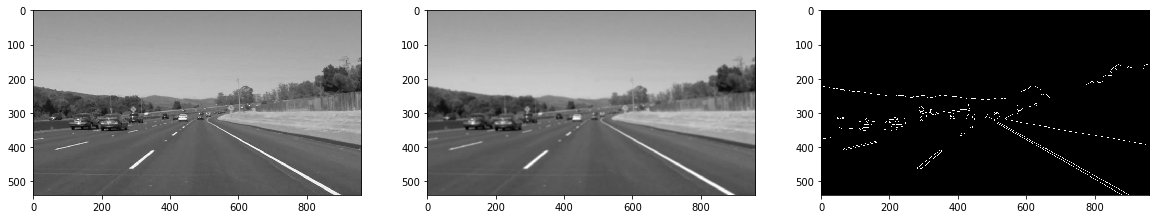

In [18]:
f, axarr = plt.subplots(1,3, figsize=(20,20))
axarr[0].imshow(gray, cmap='gray') 
axarr[1].imshow(blur_gray, cmap='gray') 
axarr[2].imshow(edges, cmap='Greys_r')
plt.show()